In [34]:
#set up

#load libraries
library(gbm)
library(ggplot2)
library(GGally)
library(tidyverse)
library(cowplot)

#read in data
kcDat <- read.csv('~/Documents/kc_inspections.csv',header=TRUE)

#data cleaning
#assign some variables to be factors
cat_vars <- c('year','weekday','business_location_zip','american.traditional','mexican','american.new','italian',
             'mediterranean','indian','ethiopian','grocery','asian')
kcDat[,cat_vars] <- lapply(kcDat[,cat_vars],as.factor)



Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



## The data

The `kcDat` data frame contains information on restaurant inspections in King County, Washington between 2015 and 2019. The inspection data has been merged with Yelp review information and some other variables have been engineered.


 - Variables
      - `inspection_serial_num`: unique inspection identifier
      - `business_record_id`: unique restaurant identifer
      - `inspection_date`: date of inspection
      - `inspection_score`: score for inspection; higher scores mean there were more violations/penalties
      - `activity_time`: length of inspection in minutes
      - `year`: year the inspection occurred
      - `weekday`: day of week inspection occurred
      - `viol_count`: number of violations that occurred in inspection
      - `prev_score_1` through `prev_score_4`: score of four most recent previous inspections, prev_score_1 being most recent
      - `business_location_zip`: zip code where restaurant is located
      - `asian`: indicator that restaurant serves Asian food


## Data Visualization and Exploration

Let's first explore and visualize the data to understand it better and if there are any relationships between variables.

In [2]:
head(kcDat)

inspection_serial_num,business_record_id,inspection_date,inspection_score,activity_time,year,weekday,viol_count,prev_score_1,prev_score_2,⋯,ethiopian,indonesian,singaporean,grocery,asian,log_inspection_score,log_prev_score_1,log_prev_score_2,log_prev_score_3,log_prev_score_4
DAPXVWYJI,PR0001011,2015-03-30,10,25,2015,Monday,1,10,20,⋯,0,0,0,0,0,2.302585,2.302585,2.995732,2.484907,2.302585
DAIQD6JTB,PR0001011,2015-06-23,15,40,2015,Tuesday,2,10,10,⋯,0,0,0,0,0,2.708050,2.302585,2.302585,2.995732,2.484907
DAN2JKZZU,PR0001011,2016-03-21,20,30,2016,Monday,3,15,10,⋯,0,0,0,0,0,2.995732,2.708050,2.302585,2.302585,2.995732
DA0UJUF5K,PR0001011,2016-08-16,15,30,2016,Tuesday,2,20,15,⋯,0,0,0,0,0,2.708050,2.995732,2.708050,2.302585,2.302585
DACPGS7VE,PR0001011,2017-03-28,5,30,2017,Tuesday,1,15,20,⋯,0,0,0,0,0,1.609438,2.708050,2.995732,2.708050,2.302585
DASZN0RMO,PR0001011,2018-10-29,5,40,2018,Monday,1,5,15,⋯,0,0,0,0,0,1.609438,1.609438,2.708050,2.995732,2.708050


We can explore relationships between the continuous variables easily through scatterplots. `ggpairs` in the `GGally` package will create a grid of scatter plots between variables as well as give us the correlation and density plots.

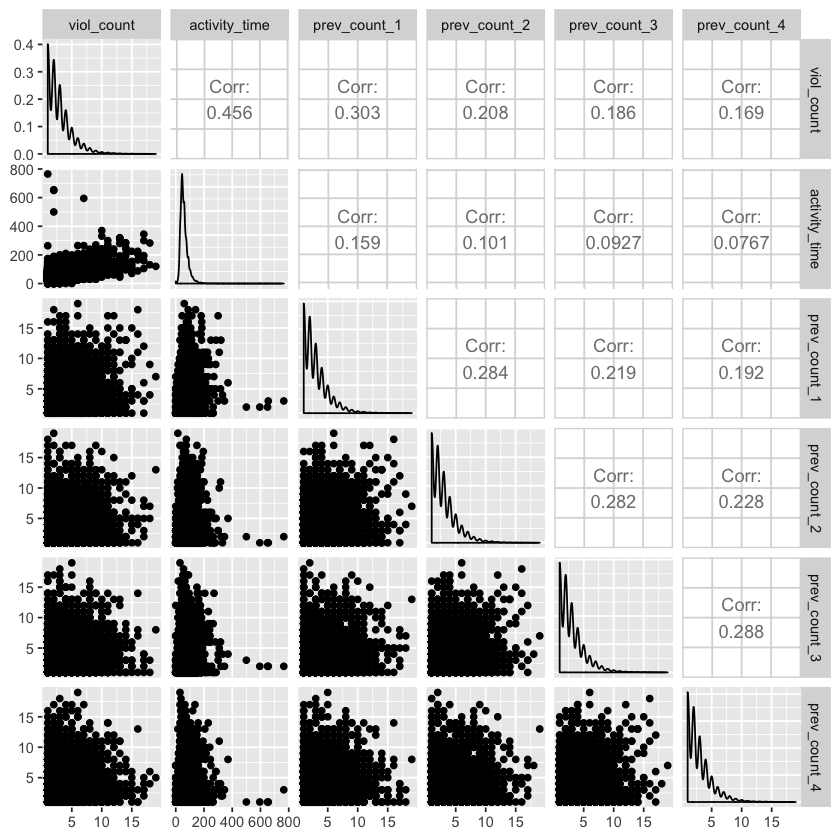

In [3]:
ggpairs(kcDat[,c('viol_count','activity_time','prev_count_1','prev_count_2','prev_count_3',
                'prev_count_4')])

## Fit a model to predict inspection scores

We would like to fit a model that predicts the score given for an inspection of a restaurant. This model would be used to predict which restaurants are expected to have higher inspection scores so inspectors could target these restaurants.

In [9]:
#get a random subset of data to fit model
set.seed(6183)
#take 80% of data to train - leave 20% to evaluate accuracy
train <- sample(1:nrow(kcDat),floor(nrow(kcDat)*.8),replace=FALSE)
train_sub <- kcDat[train,]
test_sub <- kcDat[-train,]

We'll first build a gradient boosted tree model using previous inspection scores, the time the inspections took, and the year and weekday the inspection occured.

In [10]:
predictors <- c('viol_count','prev_count_1','prev_count_2','prev_count_3','prev_count_4','year','weekday')
gb <- gbm(viol_count~prev_count_1 + prev_count_2 + prev_count_3 + prev_count_4 +
          year + weekday,
          data=train_sub[,predictors],distribution = "gaussian",n.trees = 1000,shrinkage = 0.01, interaction.depth = 2,cv.folds=6)


[1] 1.958972

[1] 718

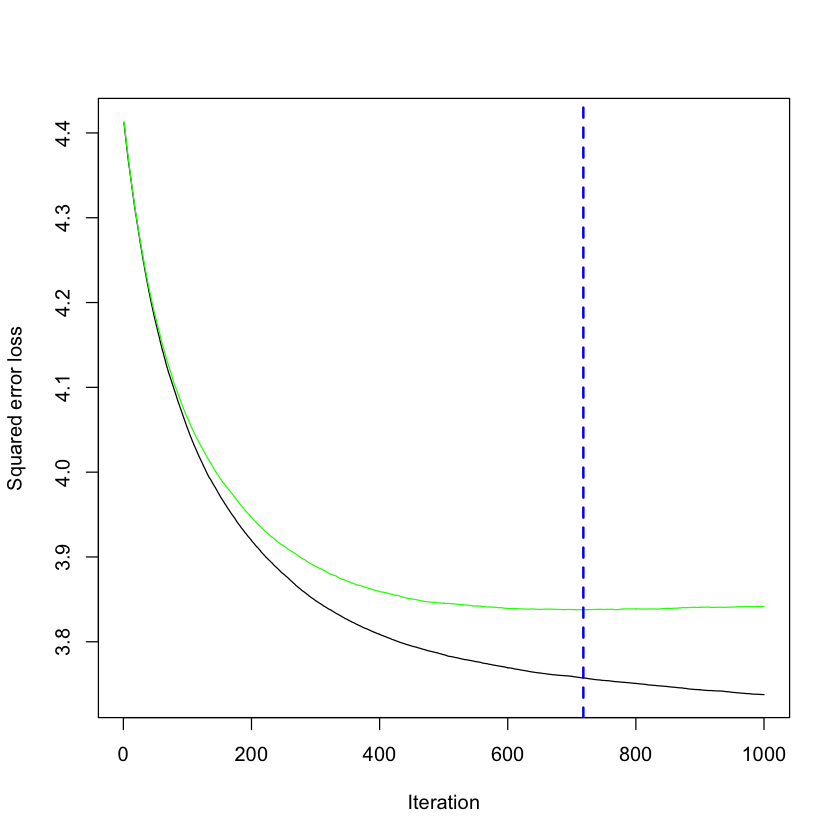

In [11]:
sqrt(min(gb$cv.error))
gbm.perf(gb, method = "cv")

## Assess prediction ability

Now that we've fit a model, how well does it actually predict the inspection score? We'll calculate the square root of the mean squared error (RMSE) on the 20% of data we kept as a test set. 

In [12]:
#predicting for test set from fitted model
score_pred <- predict(gb,newdata=test_sub,n.trees=1000)

#calculating RMSE
sqrt(mean((score_pred - test_sub$viol_count)^2))

[1] 1.979216

The RMSE is about 1.98, which means that on average, our model predicts an violation count that is 2 points off the actual score given. This is a large margin of error so our model isn't predicting very well. What might be some reasons that the model performs poorly? 

We can also graphically show how well the model is predicting by plotting the predicted values against the actual inspection scores. For a perfect model, the points would create a diagonal line. What trends do you see in the predicted vs actual scores plot?

In [53]:
#create bins by observed violation count
test_sub$prediction <- score_pred
test_sub$countCat <- ntile(test_sub$prediction,15) #using deciles to create bins

#getting mean of observed and predicted by bins
points <- aggregate(cbind(test_sub$viol_count,test_sub$prediction)~countCat,data=test_sub,mean)
midpoints <- aggregate(test_sub$prediction~countCat,data=test_sub,function(x)mean(range(x)))
points <- merge(points,midpoints,by='countCat')
counts <- test_sub %>% count(countCat)

to_plot <- merge(points,counts,by='countCat')
colnames(to_plot) <- c('countCat','meanViolCount','predViolCount','predMidpoint','n')
head(to_plot)

countCat,V1,V2
1,2.028736,2.027634
2,2.178161,2.143615
3,2.017241,2.232944
4,2.034483,2.310127
5,2.459770,2.406826
6,2.408046,2.500522


countCat,V1,V2,test_sub$prediction
1,2.028736,2.027634,2.006974
2,2.178161,2.143615,2.143870
3,2.017241,2.232944,2.229386
4,2.034483,2.310127,2.314965
5,2.459770,2.406826,2.407632
6,2.408046,2.500522,2.500299
7,2.850575,2.600972,2.602985
8,2.965318,2.718883,2.717267
9,2.637931,2.836968,2.840213
10,3.149425,2.986203,2.980643


countCat,n
1,174
2,174
3,174
4,174
5,174
6,174


countCat,meanViolCount,predViolCount,predMidpoint,n
1,2.028736,2.027634,2.006974,174
2,2.178161,2.143615,2.143870,174
3,2.017241,2.232944,2.229386,174
4,2.034483,2.310127,2.314965,174
5,2.459770,2.406826,2.407632,174
6,2.408046,2.500522,2.500299,174


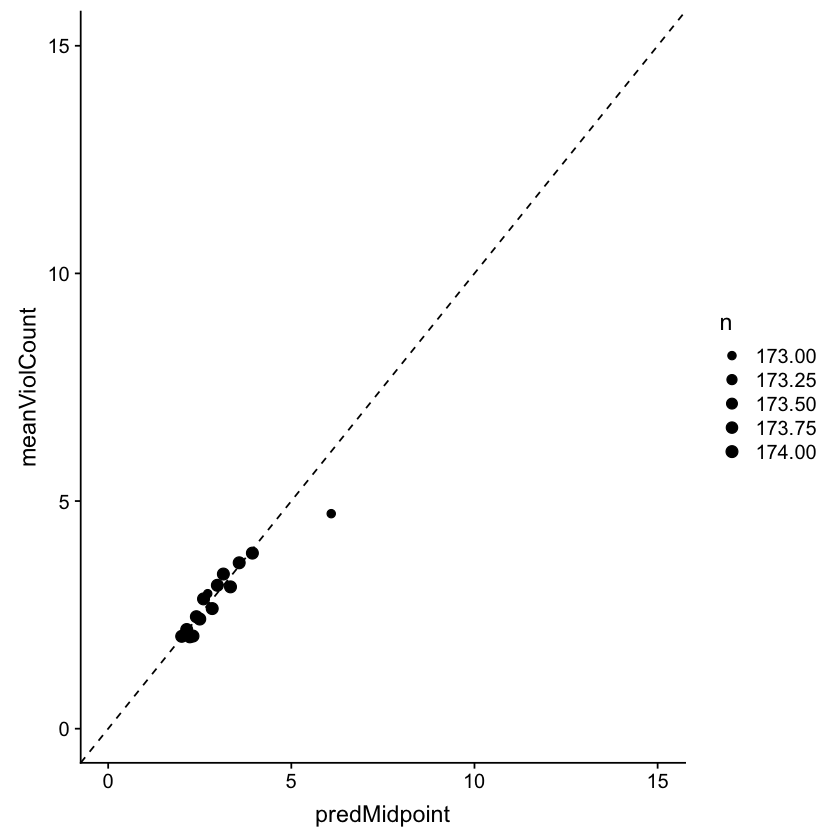

In [54]:
ggplot(to_plot,aes(x=predMidpoint,y=meanViolCount)) + geom_point(aes(size = n)) + geom_abline(linetype = "dashed") +
    scale_x_continuous(limits = c(0, 15)) +
    scale_y_continuous(limits = c(0, 15)) +
    scale_size_continuous(range = c(2,  3))

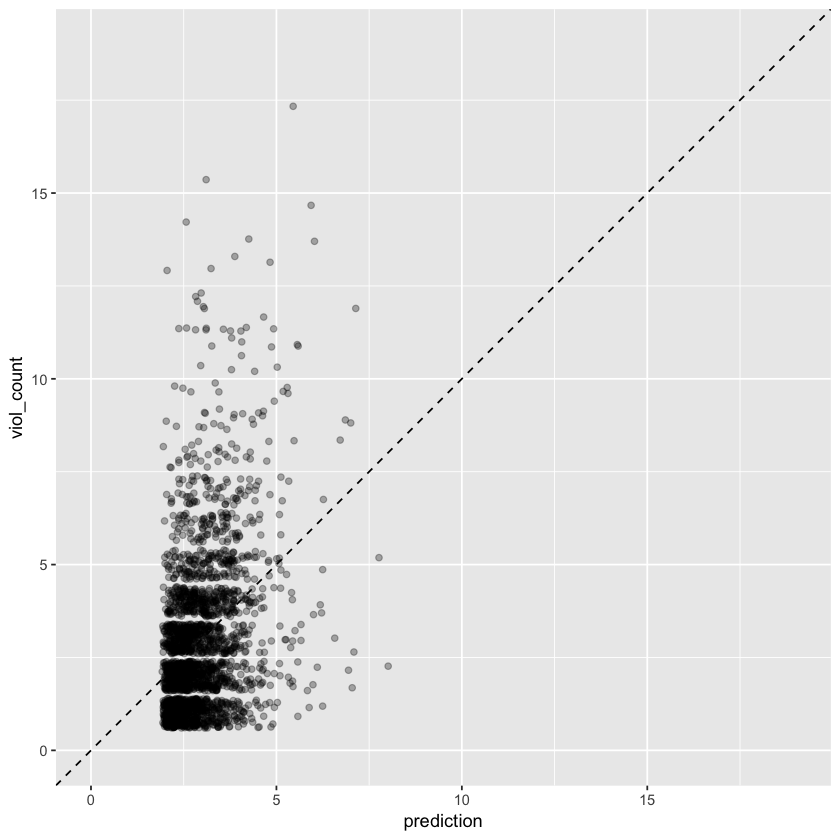

In [15]:
ggplot(test_sub,aes(x=prediction,y=viol_count)) + geom_jitter(alpha=.3) + geom_abline(linetype = "dashed") +
  
  scale_x_continuous(limits = c(0, 19)) +
  scale_y_continuous(limits = c(0, 19))

Variable importance measures can be used to see which variables are driving the predictive ability of the model. The importance measure (rel.inf, which stand for relative influence) used here is based off the number of times a variable is used for splitting the trees in the model, weighted by the squared improvement to the model after each split, averaged over all the trees in the model. Which variable seems to be driving the predictive ability of this model? Why might this variable have a lot of influence on the predicted score?

,var,rel.inf
prev_count_1,prev_count_1,49.839429
prev_count_2,prev_count_2,17.664169
prev_count_4,prev_count_4,10.541729
prev_count_3,prev_count_3,10.160345
year,year,9.654220
weekday,weekday,2.140107


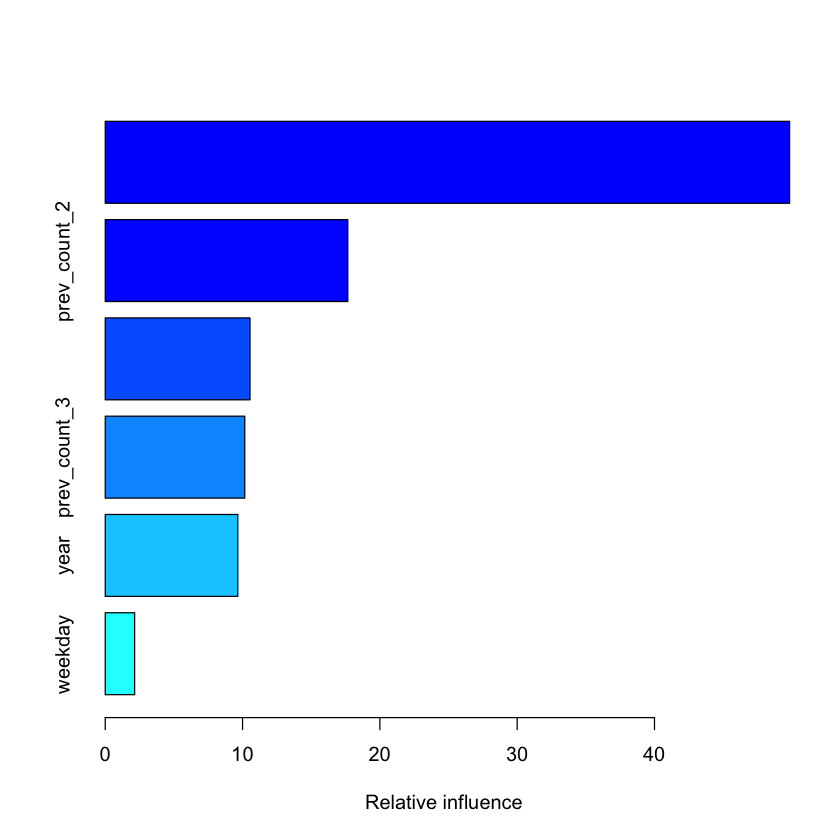

In [17]:
summary(gb)

## Adding zip code to the model

Let's add the zip code to the model to see if this improves the predictive ability.

In [18]:
#gradient boosted tree model with zip code
gb_zipcode <- gbm(viol_count~prev_count_1 + prev_count_2 + prev_count_3 + prev_count_4 +
          year + weekday + business_location_zip,data=train_sub
          ,distribution = "gaussian",n.trees = 1000,shrinkage = 0.01, interaction.depth = 2)

In [19]:
#predict the inspection scores and calculate RMSE
score_pred_zip <- predict(gb_zipcode,newdata=test_sub,n.trees=1000)

sqrt(mean((score_pred_zip-test_sub$viol_count)^2))

[1] 1.976373

There is a very small decrease in RMSE (.003) when zip code is included in the model. We can also look at variable importance again to see if these measures have changed after including zip code.

,var,rel.inf
business_location_zip,business_location_zip,42.8881750
prev_count_1,prev_count_1,32.1107082
prev_count_2,prev_count_2,9.7410658
prev_count_4,prev_count_4,5.1892498
year,year,5.0887063
prev_count_3,prev_count_3,4.8337194
weekday,weekday,0.1483756


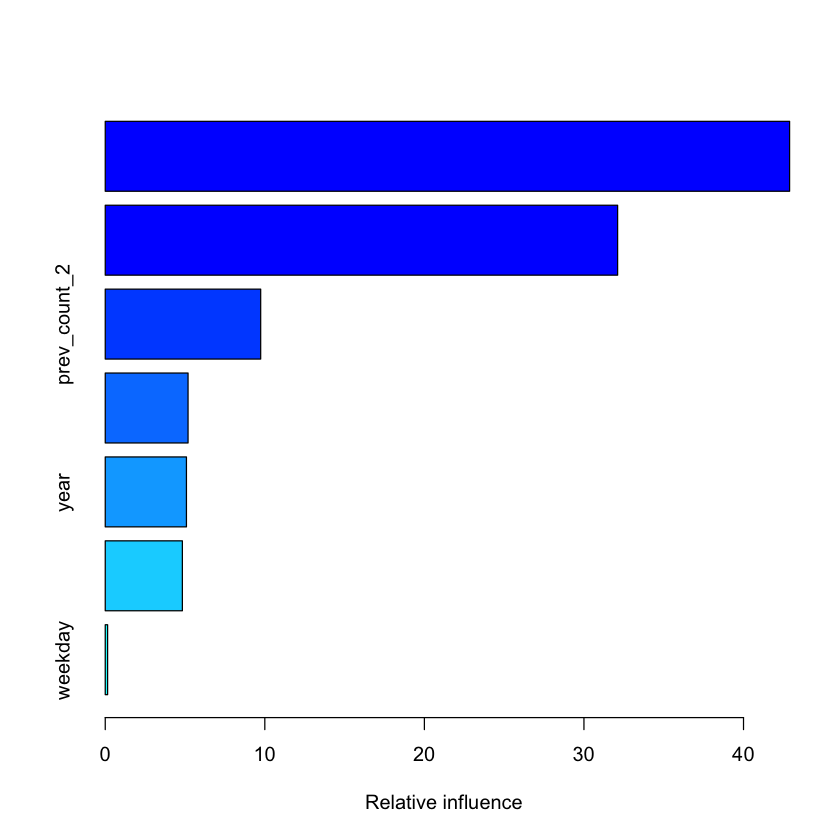

In [20]:
summary(gb_zipcode)

Zip codes seem to be the most influential variable now. However, inspectors are assigned by zip code, and some inspectors are more harsh than others when grading (see https://www.thestranger.com/seattle/mr-clean/Content?oid=568012 ). What will this mean if the allocation of resources for inspections is dictated by a model that takes zip code into account when predicting scores?

Since zip code became the most influential variable but the predictive ability hasn't changed, what might this mean about the information the other variables in the model are representing?

## Including cuisine category

Let's try adding the Asian restaurant indicator to see if this extra variable will improve accuracy.

In [21]:
gb_asian <- gbm(viol_count~prev_count_1 + prev_count_2 + prev_count_3 + prev_count_4 +
          year + weekday + asian,data=train_sub
          ,distribution = "gaussian",n.trees = 1000,shrinkage = 0.01, interaction.depth = 2)

In [22]:
#predict the inspection scores and calculate RMSE
score_pred_asian <- predict(gb_asian,newdata=test_sub,n.trees=1000)
test_sub$prediction_w_asian <- score_pred_asian

sqrt(mean((score_pred-test_sub$viol_count)^2))

[1] 1.979216

,var,rel.inf
prev_count_1,prev_count_1,46.924147
prev_count_2,prev_count_2,14.775179
asian,asian,11.162300
year,year,8.667618
prev_count_3,prev_count_3,8.220508
prev_count_4,prev_count_4,7.990649
weekday,weekday,2.259598


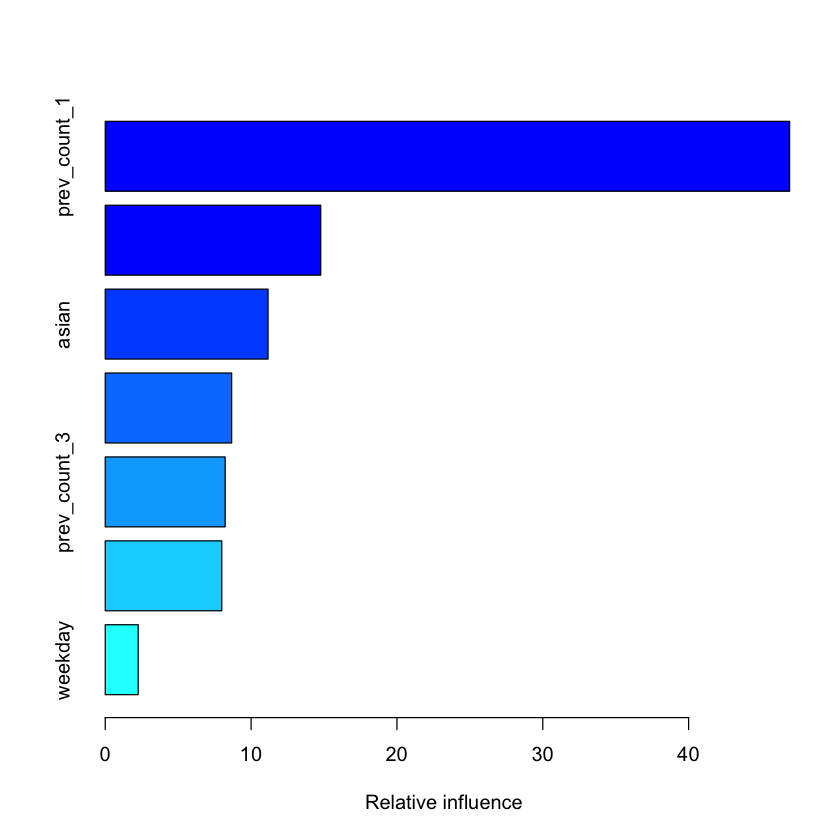

In [23]:
#look at variable importance
summary(gb_asian)

Looking at the RMSE and variable importance, including the Asian food indicator doesn't seem to improve the model either. It is the least influential variable relative to the others in the model, and the RMSE is very close to the previous two models explored. We can look futher into how the Asian food indicator is affected the prediction by plotting predicted versus actual inspections scores and splitting the two plots by whether the restaurant serves Asian food or not.

In [36]:
head(to_plot)

countCat,meanViolCount,predViolCount,predMidpoint,n
1,2.065134,2.058708,2.032351,261
2,2.084291,2.210753,2.205566,261
3,2.229885,2.334533,2.337130,261
4,2.371648,2.477117,2.478082,261
5,2.907692,2.629235,2.632045,260
6,2.727969,2.808303,2.810120,261


In [55]:
test_sub$countCatAsian <- ntile(test_sub$prediction_w_asian,15)

#data for calibration plot for model with asian                       
points_asian <- aggregate(cbind(test_sub$viol_count,test_sub$prediction_w_asian)~countCatAsian,
                         data=test_sub,mean)
midpoints_asian <- aggregate(prediction_w_asian~ countCatAsian,data=test_sub,
                            function(x)mean(range(x)))
points_asian <- merge(points_asian,midpoints_asian,by=c('countCatAsian'))
counts_asian <- test_sub %>% count(countCatAsian)
to_plot_asian <- merge(points_asian,counts_asian,by=c('countCatAsian'))
colnames(to_plot_asian) <- c('countCatAsian','meanViolCount','meanPredcount','predMidpoint','n')
head(to_plot_asian)                    

countCatAsian,meanViolCount,meanPredcount,predMidpoint,n
1,1.965517,1.976775,1.966834,174
2,2.103448,2.090756,2.085236,174
3,1.913793,2.177000,2.175193,174
4,2.109195,2.272971,2.270840,174
5,2.275862,2.377991,2.379478,174
6,2.678161,2.489355,2.491795,174


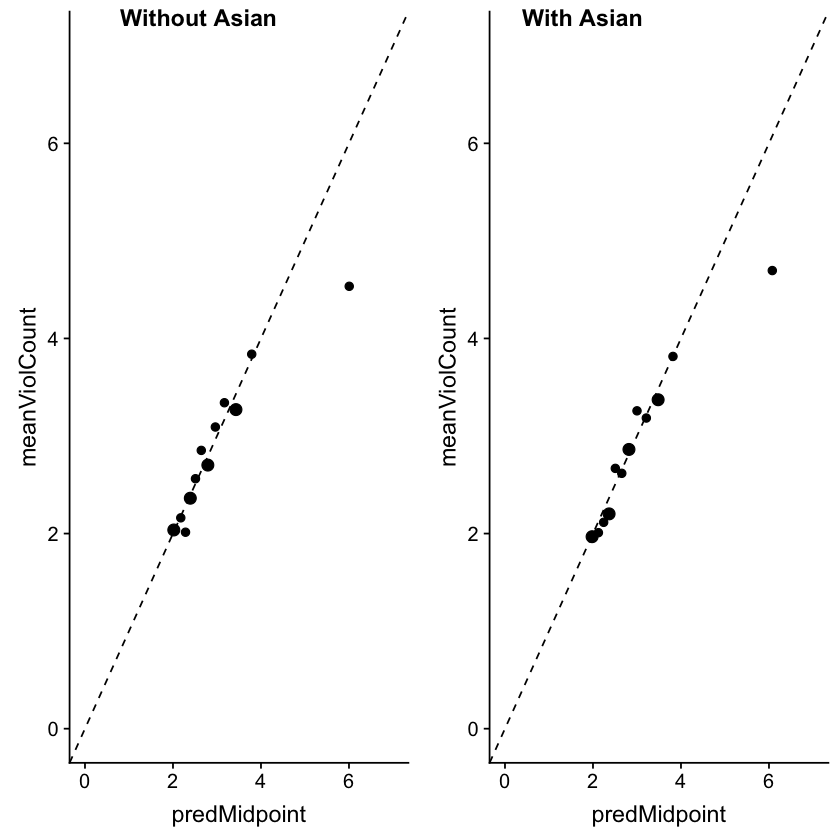

In [52]:
calib_plot  <- ggplot(to_plot,aes(x=predMidpoint,y=meanViolCount)) + geom_point(aes(size = n)) + geom_abline(linetype = "dashed") +
    scale_x_continuous(limits = c(0, 7)) +
    scale_y_continuous(limits = c(0, 7)) +
    scale_size_continuous(range = c(2,  3)) + theme(legend.position='none')

calib_plot_asian <- ggplot(to_plot_asian,aes(x=predMidpoint,y=meanViolCount)) + geom_point(aes(size = n)) + geom_abline(linetype = "dashed") +
    scale_x_continuous(limits = c(0, 7)) +
    scale_y_continuous(limits = c(0, 7)) +
    scale_size_continuous(range = c(2,  3)) + theme(legend.position='none')

plot_grid(calib_plot, calib_plot_asian,align='hv',labels=c('Without Asian','With Asian'),label_x=0.1)


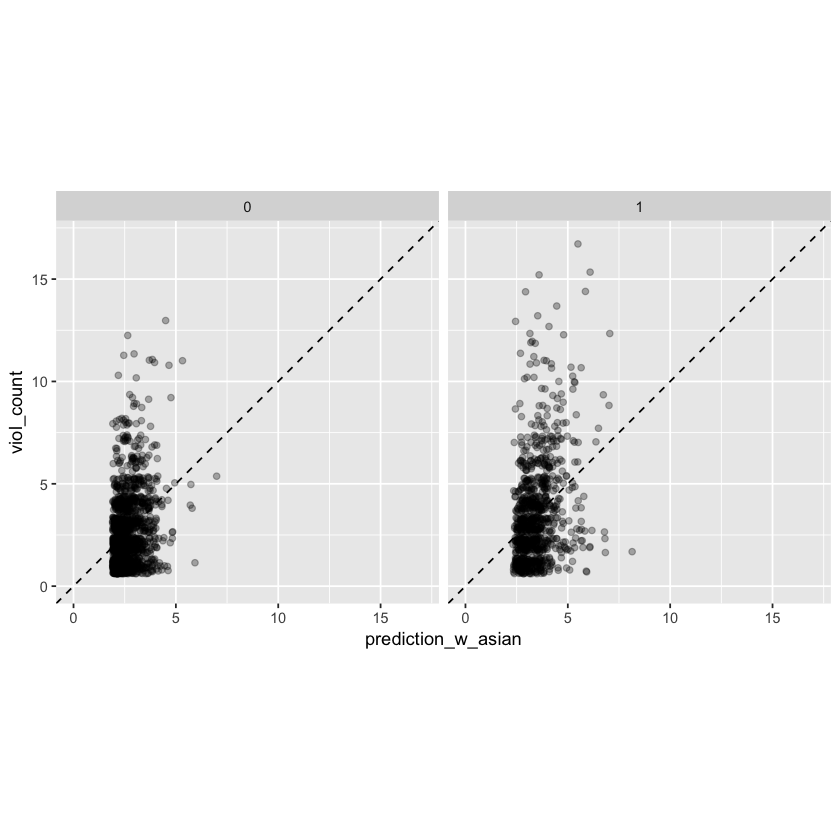

In [31]:
ggplot(test_sub,aes(x=prediction_w_asian,y=viol_count)) + geom_abline(linetype = "dashed") +
  geom_jitter(alpha=0.3) +
  facet_grid(cols = vars(asian)) + coord_fixed() +
  scale_x_continuous(limits = c(0, 17)) +
  scale_y_continuous(limits = c(0, 17))

What differences do you see between the Asian food restaurants and non-Asian restaurants?